## Steel Defect Detection
This is starter kernel.<BR>
I used many kernels as a reference for creating this kernel. Especially,<BR>
["clear mask visualization and simple eda (GoldFish)"](https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda) for image data visualization.<BR>
["RLE functions - Run Lenght Encode & Decode (Paulo Pinto)"](https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode) for rle encode-decode.<BR>
["Intro - chest xray, DICOM, viz, U-nets - full data (Jesper)"](https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data#Vanilla-Unet) for model

In [1]:
import os
from pathlib import Path
from tqdm import tqdm
import json

import numpy as np # linear algebra
import pandas as pd
#pd.set_option("display.max_rows", 101)
import math

import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 10
import seaborn as sns
from PIL import Image

from collections import Counter
from collections import defaultdict

from keras.layers import *
from keras.models import Model
from keras.optimizers import *
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
DIRin1 = "/kaggle/input/severstal/severstal"
print("DIRin1 =", os.listdir(DIRin1))
DIRtrain = os.path.join(DIRin1,"train_images")
DIRtest = os.path.join(DIRin1,"test_images")

# DIRin2 = "../input/defect-detection-training"
# print("DIRin2 =", os.listdir(DIRin2))
# save path
# weights_path = os.path.join(DIRin2,"DefectDetection.h5")
# history_path = os.path.join(DIRin2,"DefectDetection_history.csv")

print("Num of Train img\t:",len(os.listdir(DIRtrain)))
print("Num of Test img\t\t:",len(os.listdir(DIRtest)))

DIRin1 = ['train_images', 'train.csv', 'test.csv', 'test_images']
Num of Train img	: 11562
Num of Test img		: 1006


Training is inadequate at the regular time of the one-hour competition. So I traind 50 epochs on my local PC (about 3 hours). And This kernel does not perform any further training, but uses pre-learned weights data.<BR>
If you want to train, set `NoTRAIN = False`.

In [3]:
##### Training conditions ##### 
batch_size = 16

NoTRAIN = False    # True:No further training, use pre-learned weights
RESUME = False    # True:Resume Training, False:Start from the beginning

if RESUME:
    initial_epoch = 50    # initial_epoch when training resumes
else:
    initial_epoch = 0
epochs = initial_epoch + 30
steps_per_epoch = 200

## Image Data confirmation

In [4]:
train_df = pd.read_csv(os.path.join(DIRin1, "train.csv"))
train_df.head()

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

In [5]:
# Transform class to column
train_df['fname'] = train_df["ImageId"]
train_df['cls'] = train_df["ClassId"]
train_df['cls'] = train_df["cls"].astype(int) # for origin severstal dataset
train_df = train_df.pivot(index='fname',columns='cls',values='EncodedPixels')
train_df['defects'] = train_df.count(axis=1)
#train_df.reset_index()
train_df.head(10)

cls                                                            1  \
fname                                                              
0002cc93b.jpg  29102 12 29346 24 29602 24 29858 24 30114 24 3...   
0007a71bf.jpg                                                NaN   
000a4bcdd.jpg  37607 3 37858 8 38108 14 38359 20 38610 25 388...   
000f6bf48.jpg                                                NaN   
0014fce06.jpg                                                NaN   
0025bde0c.jpg                                                NaN   
002af848d.jpg                                                NaN   
002fc4e19.jpg  146021 3 146275 10 146529 40 146783 46 147038 ...   
0030401a5.jpg                                                NaN   
0046839bd.jpg                                                NaN   

cls                                                            2  \
fname                                                              
0002cc93b.jpg                                                NaN   
0007a71bf.jpg                                                NaN   
000a4bcdd.jpg                                                NaN   
000f6bf48.jpg                                                NaN   
0014fce06.jpg                                                NaN   
0025bde0c.jpg                                                NaN   
002af848d.jpg                                                NaN   
002fc4e19.jpg  145658 7 145901 20 146144 33 146386 47 146629 ...   
0030401a5.jpg                                                NaN   
0046839bd.jpg                                                NaN   

cls                                                            3  \
fname                                                              
0002cc93b.jpg                                                NaN   
0007a71bf.jpg  18661 28 18863 82 19091 110 19347 110 19603 11...   
000a4bcdd.jpg                                                NaN   
000f6bf48.jpg                                                NaN   
0014fce06.jpg  229501 11 229741 33 229981 55 230221 77 230468...   
0025bde0c.jpg  8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...   
002af848d.jpg                                                NaN   
002fc4e19.jpg                                                NaN   
0030401a5.jpg                                                NaN   
0046839bd.jpg  152926 1 153180 4 153434 6 153689 8 153943 11 ...   

cls                                                            4  defects  
fname                                                                      
0002cc93b.jpg                                                NaN        1  
0007a71bf.jpg                                                NaN        1  
000a4bcdd.jpg                                                NaN        1  
000f6bf48.jpg  131973 1 132228 4 132483 6 132738 8 132993 11 ...        1  
0014fce06.jpg                                                NaN        1  
0025bde0c.jpg  315139 8 315395 15 315651 16 315906 17 316162 ...        2  
002af848d.jpg  290800 6 291055 13 291311 15 291566 18 291822 ...        1  
002fc4e19.jpg                                                NaN        2  
0030401a5.jpg  186833 1 187089 3 187344 6 187600 7 187855 10 ...        1  
0046839bd.jpg                                                NaN        1

In [6]:
# Presence of defects in each images
no_defects_num = np.sum(train_df['defects'] == 0)
defects_num = len(train_df) - no_defects_num
print("no_defect imgs \t:", no_defects_num)
print("defects imgs \t:", defects_num)

no_defect imgs 	: 0
defects imgs 	: 6666


In [7]:
# Number of defects for each class
class_defects = len(train_df) - train_df.isnull().sum() # class毎の欠陥数
class_defects[:4]

cls
1     897
2     247
3    5150
4     801
dtype: int64

In [8]:
# check images size
train_size = defaultdict(int)
test_size = defaultdict(int)

for fPath in Path(DIRtrain).iterdir():
    img = Image.open(fPath)
    train_size[img.size] += 1
for fPath in Path(DIRtest).iterdir():
    img = Image.open(fPath)
    test_size[img.size] += 1
    
print("train_img_size :",train_size)
print("test_img_size  :",test_size)

train_img_size : defaultdict(<class 'int'>, {(1600, 256): 11562})
test_img_size  : defaultdict(<class 'int'>, {(1600, 256): 1006})


## Visualization

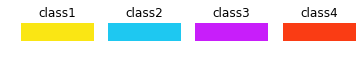

In [9]:
palet = [(250, 230, 20), (30, 200, 241), (200, 30, 250), (250,60,20)]

fig, ax = plt.subplots(1, 4, figsize=(6, 2))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((10, 40, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class{}".format(i+1))

plt.show()

In [10]:
def mask2rgba(mask):
    rgba_list = []
    for idx in range(4):    # idx: class id
        rgba = cv2.cvtColor(mask[:, :, idx], cv2.COLOR_GRAY2RGBA)
        rgba[:, :, :3] = rgba[:, :, :3] /255 * palet[idx]
        rgba_list.append(rgba)
    return rgba_list

In [11]:
def make_mask(row_id):
    fname = train_df.iloc[row_id].name

    labels = train_df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.uint8)    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 255
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

In [12]:
def show_mask_image(row_id, contour = True):
    name, mask = make_mask(row_id)
    img = cv2.imread(os.path.join(DIRtrain, name))

    if contour:
        for ch in range(4):
            contours, _ = cv2.findContours(mask[:, :, ch],
                            cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            for i in range(0, len(contours)):
                cv2.polylines(img, contours[i], True, palet[ch], 2)
    else:
        for ch in range(4):
            img[mask[:,:,ch]==255] = palet[ch]
        
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_title(name)
    ax.imshow(img)
    ax.axis('off')
    plt.show()

In [13]:
# classify defects
idx_class_1 = list(filter(lambda r:not pd.isna(train_df.iloc[r,0]), range(len(train_df))))
idx_class_2 = list(filter(lambda r:not pd.isna(train_df.iloc[r,1]), range(len(train_df))))
idx_class_3 = list(filter(lambda r:not pd.isna(train_df.iloc[r,2]), range(len(train_df))))
idx_class_4 = list(filter(lambda r:not pd.isna(train_df.iloc[r,3]), range(len(train_df))))
# Nouber of defects class
idx_no_defect = list(filter(lambda r:train_df.iloc[r,4] == 0, range(len(train_df))))
idx_1_defect = list(filter(lambda r:train_df.iloc[r,4] == 1, range(len(train_df))))
idx_class_multi = list(filter(lambda r:train_df.iloc[r,4] >= 2, range(len(train_df))))

In [14]:
# no defect sumple
for idx in idx_no_defect[:3]:
    show_mask_image(idx)

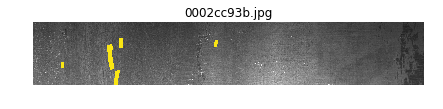

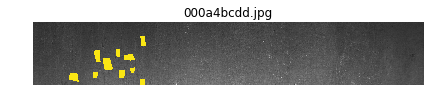

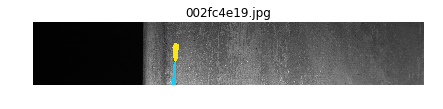

In [15]:
# class_1 defect sumple (Yellow)
for idx in idx_class_1[:3]:
    show_mask_image(idx, contour=False)

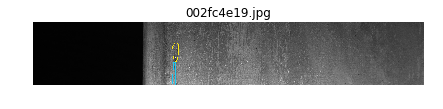

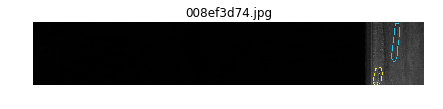

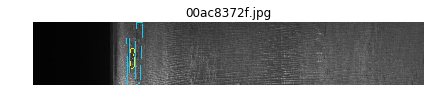

In [16]:
# class_2 defect sumple (lightblue)
for idx in idx_class_2[:3]:
    show_mask_image(idx, contour=True)

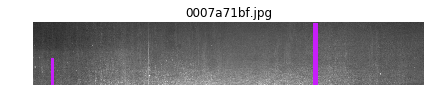

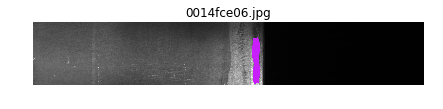

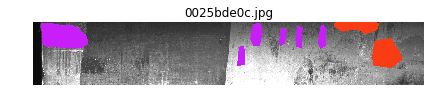

In [17]:
# class_3 defect sumple (purple)
for idx in idx_class_3[:3]:
    show_mask_image(idx, contour=False)

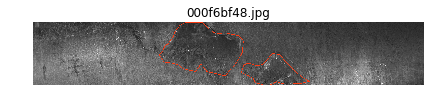

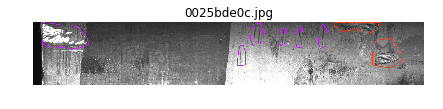

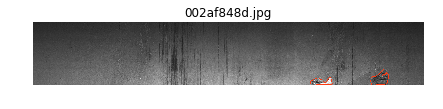

In [18]:
# class_4 defect sumple (red)
for idx in idx_class_4[:3]:
    show_mask_image(idx, contour=True)

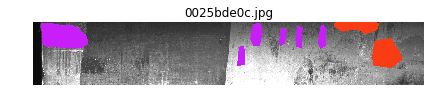

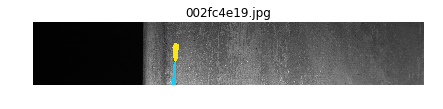

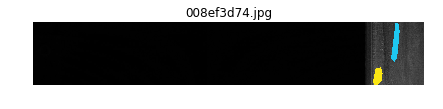

In [19]:
# contain multi class defects
for idx in idx_class_multi[:3]:
    show_mask_image(idx, contour=False)

## Model

In [20]:
# U-Net
# https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data#Vanilla-Unet

input_shape = (256, 1600, 1)
inputs = Input(input_shape)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
u6 = concatenate([u6, c5])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

# Load pre-traind weights
if (NoTRAIN or RESUME) and os.path.exists(weights_path):
    model.load_weights(weights_path)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 1600, 8) 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 800, 8)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [21]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) \
            / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [22]:
optimizer = Adam()
model.compile(optimizer, 'binary_crossentropy', metrics=[dice_coef])

## Prepare Training

In [23]:
# Train Data Generator
def Xy_generator(ids, batch_size):
    Xs = []; ys = []
    while True:
        for i in ids:
            name, mask = make_mask(i)
            img = cv2.imread(os.path.join(DIRtrain, name),
                             cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = img[..., np.newaxis]    # Add channel axis
            img = img / 255.           # 0～1
            mask = mask / 255.         # 0～1
            Xs.append(img); ys.append(mask)
            if len(Xs) == batch_size:
                X = np.array(Xs); y = np.array(ys)
                Xs = []; ys = []
                yield [X, y]

In [24]:
# Train Data
train_ids, val_ids = train_test_split(range(len(train_df)), test_size=0.2)
train_gen = Xy_generator(train_ids, batch_size)
val_gen = Xy_generator(val_ids, batch_size)

X.shape: (4, 256, 1600, 1) 
y.shape: (4, 256, 1600, 4)


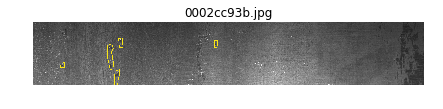

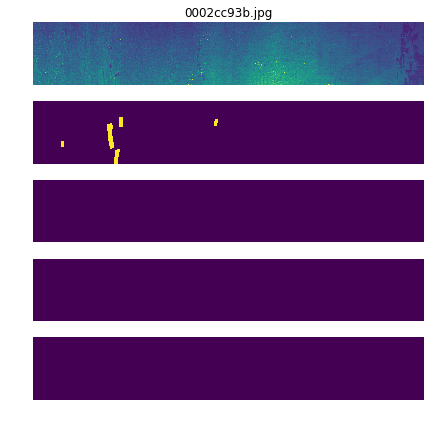

In [25]:
# generator test
for X, y in Xy_generator(range(len(train_df)), 4):
    break

print('X.shape:',X.shape, '\ny.shape:',y.shape)

row = 0
# from train_df
show_mask_image(row, contour=True)
# from generator
fig, axs = plt.subplots(5, figsize=(7,7))
axs[0].imshow(X[row,:,:,0])
axs[0].axis('off')
axs[0].set_title(train_df.iloc[row].name)
for i in range(4):
    axs[i+1].imshow(y[row,:,:,i])
    axs[i+1].axis('off')

## Training

In [26]:
# Callback
checkpoint = ModelCheckpoint("model.h5", monitor='val_dice_coef',
                             verbose=1,save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [27]:
# remove previous results
%rm model.h5
%rm state.db
%rm submission.csv

rm: cannot remove 'model.h5': No such file or directory
rm: cannot remove 'state.db': No such file or directory
rm: cannot remove 'submission.csv': No such file or directory


training for  50 epochs with 50 steps per epoch took 0 hours 46 mins 17 sec

training for 200 epochs with 59 steps per epoch took 3 hours 27 mins 28 sec

In [28]:
# Fit
if NoTRAIN == False or RESUME:
    history = model.fit_generator(generator=train_gen,
                              steps_per_epoch=steps_per_epoch,
                              initial_epoch=initial_epoch,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps = len(val_ids)//batch_size,
                              verbose=2,
                              shuffle=True,
                              callbacks=callbacks_list)

Epoch 1/30
 - 169s - loss: 0.1651 - dice_coef: 0.0523 - val_loss: 0.0560 - val_dice_coef: 0.1133

Epoch 00001: val_dice_coef improved from -inf to 0.11334, saving model to model.h5
Epoch 2/30
 - 141s - loss: 0.0483 - dice_coef: 0.1437 - val_loss: 0.0456 - val_dice_coef: 0.1927

Epoch 00002: val_dice_coef improved from 0.11334 to 0.19273, saving model to model.h5
Epoch 3/30
 - 143s - loss: 0.0421 - dice_coef: 0.2821 - val_loss: 0.0391 - val_dice_coef: 0.3293

Epoch 00003: val_dice_coef improved from 0.19273 to 0.32934, saving model to model.h5
Epoch 4/30
 - 142s - loss: 0.0380 - dice_coef: 0.3302 - val_loss: 0.0364 - val_dice_coef: 0.3931

Epoch 00004: val_dice_coef improved from 0.32934 to 0.39308, saving model to model.h5
Epoch 5/30
 - 142s - loss: 0.0352 - dice_coef: 0.3557 - val_loss: 0.0363 - val_dice_coef: 0.3689

Epoch 00005: val_dice_coef did not improve from 0.39308
Epoch 6/30
 - 141s - loss: 0.0353 - dice_coef: 0.3806 - val_loss: 0.0341 - val_dice_coef: 0.3880

Epoch 00006: va

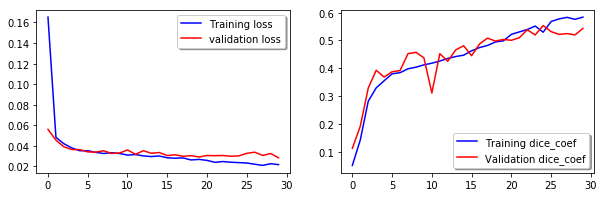

In [29]:
# Plot the loss and dice_coef curves
if (NoTRAIN or RESUME) and os.path.exists(history_path):
    hist_df = pd.read_csv(history_path)        # Load previous training history
if RESUME and os.path.exists(history_path):
    hist_df1 = pd.DataFrame(history.history)[['loss','val_loss','dice_coef','val_dice_coef']]
    hist_df = pd.concat([hist_df, hist_df1], ignore_index=True)    # Concat history
elif NoTRAIN == False and RESUME == False:
    hist_df = pd.DataFrame(history.history)[['loss','val_loss','dice_coef','val_dice_coef']]

# Plot
fig, ax = plt.subplots(1,2,figsize=(10, 3))

ax[0].plot(hist_df['loss'], color='b', label="Training loss")
ax[0].plot(hist_df['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist_df['dice_coef'], color='b', label="Training dice_coef")
ax[1].plot(hist_df['val_dice_coef'], color='r',label="Validation dice_coef")
legend = ax[1].legend(loc='best', shadow=True)

In [30]:
# Save history (for next Resume)
hist_df.to_csv("DefectDetection_history.csv", index=False)

## Predict

In [31]:
# Load the weights that had the best score for predict
if NoTRAIN == False or RESUME:
    model.load_weights("model.h5")

In [32]:
# Binarize the mask output by NN
def binarize(masks, th = 0.5):
    # Maximum value of each channel per pixel
    mask_max = np.zeros_like(masks[:,:,0])
    mask_max = np.fmax(masks[:,:,0],masks[:,:,1])
    mask_max = np.fmax(mask_max,masks[:,:,2])
    mask_max = np.fmax(mask_max,masks[:,:,3])
    # Remove non-maximum pixels
    m = np.zeros_like(masks)
    for ch in range(4):
        m[:,:,ch] = (masks[:,:,ch] == mask_max) * masks[:,:,ch]
    # Binarization
    m = (m>th) * 1
    return m

In [33]:
def show_predict_img(df, row):
    if df == "train_df":
        name = train_df.iloc[row].name
        img = cv2.imread(os.path.join(DIRtrain, name),
                             cv2.IMREAD_GRAYSCALE)
    else:
        if df == "submit_df":
            name = test_df.iloc[row//4,0].split('_')[0]
        elif df == "test_df":
            name = test_df.iloc[row,0]
        img = cv2.imread(os.path.join(DIRtest, name),
                             cv2.IMREAD_GRAYSCALE)

    img_ = img[..., np.newaxis]    # Add channel axis
    img_ = img_[np.newaxis, ...]    # Add batch axis
    img_ = img_ / 255.              # 0～1

    pred_masks = model.predict(img_)
    bin_masks = binarize(pred_masks[0, ...], 0.5)

    fig, axs = plt.subplots(5,2, figsize=(12, 6))
    axs[0,0].imshow(img)
    axs[0,0].axis('off')
    axs[0,0].set_title(name)
    axs[0,1].axis('off')
    axs[0,1].set_title("after binarize")
    for i in range(4):
        axs[i+1,0].imshow(pred_masks[0,:,:,i])
        axs[i+1,0].axis('off')
        axs[i+1,0].set_title('class '+ str(i+1))
        axs[i+1,1].imshow(bin_masks[:,:,i])
        axs[i+1,1].axis('off')
        axs[i+1,1].set_title('class '+ str(i+1))

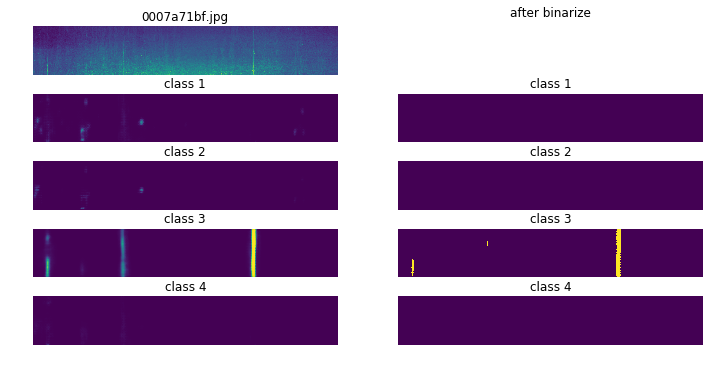

In [34]:
# predict sumple
show_predict_img("train_df", 1)

## Submission

In [35]:
submit_df = pd.read_csv("/kaggle/input/severstal/submit.csv")
submit_df['EncodedPixels'] = np.nan
submit_df['ClassId'] = 0
print(len(submit_df)) # 1006 for my test dataset
submit_df.head(10)

1006


ImageId  ClassId  EncodedPixels
0  0030401a5.jpg        0            NaN
1  008479d08.jpg        0            NaN
2  00c6060db.jpg        0            NaN
3  00ded7837.jpg        0            NaN
4  00fe04c98.jpg        0            NaN
5  018ccdfed.jpg        0            NaN
6  01e501f99.jpg        0            NaN
7  023353d24.jpg        0            NaN
8  02449f836.jpg        0            NaN
9  026183d85.jpg        0            NaN

In [36]:
temp_df = pd.DataFrame()
temp_df['ImageId'] = submit_df['ImageId']
test_df = pd.DataFrame(temp_df['ImageId'].unique(), columns=['ImageId'])
print(len(test_df))
test_df.head()

1006


ImageId
0  0030401a5.jpg
1  008479d08.jpg
2  00c6060db.jpg
3  00ded7837.jpg
4  00fe04c98.jpg

In [37]:
def mask2rle(mask):
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[:-1:2]
    return ' '.join(str(x) for x in runs)

In [38]:
def build_rles(masks):
    width, height, depth = masks.shape
    masks = binarize(masks, th = 0.5)
    rles = [mask2rle(masks[:, :, i]) for i in range(depth)]

    return rles

In [39]:
# Predict test images
# origin code

# for i, line in tqdm(test_df.iterrows()):
#    img = cv2.imread(os.path.join(DIRtest, line['ImageId']),
#                     cv2.IMREAD_GRAYSCALE)
#    img = img[..., np.newaxis]    # Add channel axis
#    img = img[np.newaxis, ...]    # Add butch axis
#    img = img / 255.              # 0～1
#    pred_masks = model.predict(img)[0]
#    rles = build_rles(pred_masks)
#    for j in range(4):
#        if len(rles[j])>0:
#            submit_df.iloc[i*4+j,1] = rles[j]

In [40]:
%mkdir masks

In [41]:
def getRGBvalues(defectId: int):
    if defectId == 0:
        return (255, 0, 0)
    if defectId == 1:
        return (0, 255, 0)
    if defectId == 2:
        return (0, 0, 255)
    if defectId == 3:
        return (128, 0, 255)
    else:
        return (0, 0, 0)

In [42]:
# Predict test images with saving
# my edit
#"(255, 0, 0)": 0, # dimple
#"(0, 255, 0)": 1, # scratch
#"(0, 0, 255)": 2, # abrasion
#"(128, 0, 255)": 3 # blister
masks_saved = 0
print(len(test_df))
for i, line in tqdm(test_df.iterrows()):
    img = cv2.imread(os.path.join(DIRtest, line['ImageId']),
                     cv2.IMREAD_GRAYSCALE)
    img = img[..., np.newaxis]    # Add channel axis
    img = img[np.newaxis, ...]    # Add butch axis
    img = img / 255.              # 0～1
    pred_masks = model.predict(img)[0]
    masks = binarize(pred_masks, th = 0.5)
    rles = build_rles(pred_masks)
    for j in range(4):
        # file name of mask is same name as source image but add class, for example 02701c239_1.png
        RGB = getRGBvalues(j)
        img_name = line["ImageId"].split(".")[0]
        fn = img_name + "_" + str(j)
        mask = masks[:, :, j]
        mask_img = np.zeros((256, 1600, 3))
        mask_img[mask == 1, 0] = RGB[0]
        mask_img[mask == 1, 1] = RGB[1]
        mask_img[mask == 1, 2] = RGB[2]
        plt.imsave("masks/"+ fn + ".png", mask_img)
        masks_saved += 1
print("Saved " + str(masks_saved) + " masks")


0it [00:00, ?it/s]

1006


1006it [03:34,  4.78it/s]

Saved 4024 masks


In [43]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [44]:
zip_dir(file_name="output.zip")

/kaggle/working/output.zip

In [45]:
# Predict test images 
# my edit with saving to csv
#rowNumber = 0
#print(len(test_df))
#for i, line in tqdm(test_df.iterrows()):
#    img = cv2.imread(os.path.join(DIRtest, line['ImageId']),
#                     cv2.IMREAD_GRAYSCALE)
#    img = img[..., np.newaxis]    # Add channel axis
#    img = img[np.newaxis, ...]    # Add butch axis
#    img = img / 255.              # 0～1
#    pred_masks = model.predict(img)[0]
#    rles = build_rles(pred_masks)
#    for j in range(4):
#        if len(rles[j])>0:
#            submit_df["ImageId"][rowNumber] = line["ImageId"]
#            submit_df["EncodedPixels"][rowNumber] = rles[j]
#            submit_df["ClassId"][rowNumber] = j
#            rowNumber += 1

In [46]:
#submit_df.head(30)

In [47]:
# Number of Defect Detection
#submit_df['EncodedPixels'].count()

In [48]:
# Detected sumple
#show_predict_img("submit_df",30)

In [49]:
#submit_df.to_csv('submission.csv', index=False)